In [1]:
import pandas as pd
import numpy as np
import igraph as ig
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
classes_path = "../elliptic_bitcoin_dataset/elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

In [3]:
label_colors = {'1':'red', '2':'green', 'unknown':'gray'}

tx_graph = ig.Graph(directed=True)

edges_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

tx_graph.add_vertices(len(classes))
tx_graph.vs['id'] = list(classes['txId'])
tx_graph.vs['type'] = list(classes['label'])
tx_graph.vs['time_step'] = list(feats['time_step'])
tx_graph.vs['color'] = [label_colors[label] for label in classes['label']]

edges_list = [(edges_dict[edges['txId1'][i]], edges_dict[edges['txId2'][i]]) for i in tqdm(range(len(edges)))]
tx_graph.add_edges(edges_list)

100%|████████████████████████████████████████████████████████████| 234355/234355 [00:00<00:00, 265730.97it/s]


In [4]:
betweenness = tx_graph.betweenness(directed=True)
df.insert(1, 'betweenness', betweenness, True)

In [5]:
centralities = tx_graph.closeness()
df.insert(1, 'closeness', centralities, True)

In [6]:
in_degree = tx_graph.degree(mode="in")
df.insert(1, 'in-degree', in_degree)

In [7]:
out_degree = tx_graph.degree(mode='out')
df.insert(1, 'out-degree', out_degree)

In [8]:
clustering_coeff = tx_graph.transitivity_local_undirected(mode='zero')
df.insert(1, 'clustering_coeff', clustering_coeff)

In [9]:
pagerank_scores = tx_graph.pagerank(directed=True)
df.insert(1, 'pagerank', pagerank_scores, True)
df.head()

,label,pagerank,clustering_coeff,out-degree,in-degree,closeness,betweenness,time_step,trans_feat_0,trans_feat_1,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
230425980,unknown,0.000004,0.000000,1,1,0.092392,14.000000,1,-0.171469,-0.184668,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5530458,unknown,0.000005,0.000000,1,1,0.084580,8.000000,1,-0.171484,-0.184668,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232022460,unknown,0.000005,0.000000,2,1,0.134507,30.000000,1,-0.172107,-0.184668,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
232438397,2,0.000297,0.000621,1,160,0.155365,2355.000000,1,0.163054,1.963790,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
230460314,unknown,0.000002,0.266667,8,2,0.100978,16.752381,1,1.011523,-0.081127,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
#Transform the dataframe in a suitable input for KMeans. We drop the columns containing
#the correct labels
x = df.drop(columns=['label']).to_numpy()

In [13]:
#k-means++ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(x)
kmeans += 1
#The following results are obtained without apllying PCA
contingency_table = pd.crosstab(index=kmeans, columns=df['label'], rownames=['Cluster'], colnames=['Original Label'])

print("\nContingency Table:")
print(contingency_table)

# Calculate totals per label in each cluster
totals_per_cluster = contingency_table.sum(axis=1)
print("\nTotals per cluster:")
print(totals_per_cluster)


Contingency Table:
Original Label     1      2  unknown
Cluster                             
1               4545  42019   155084
2                  0      0     2121

Totals per cluster:
Cluster
1    201648
2      2121
dtype: int64


In [14]:
#First set the dimensions of resulting features space
number_of_dimensions = 10
pca = PCA(n_components=number_of_dimensions)
# pca=PCA()
scaler = StandardScaler()
#Standardize features by removing the mean and scaling to unit variance.
#Note: scaler is sensible to outliers
x_scaled = scaler.fit_transform(x)
x_pca = pca.fit_transform(x_scaled)
print(pca.explained_variance_ratio_*100)

[10.06120467  6.38645543  5.33283968  4.43307308  3.8917352   3.75413629
  3.38358219  2.76272504  2.64374949  2.5719597 ]


In [15]:
print(pca.singular_values_)

[1877.83864544 1496.10895785 1367.13859705 1246.48118035 1167.89801963
 1147.06571206 1088.98436739  984.0158921   962.59462205  949.43526766]


In [16]:
#fit and predict the cluster for each sample and then adjust them for coherence with original 
#class labels
clusters = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(x_pca)
clusters += 1
unique, counts = np.unique(clusters, return_counts=True)
print('Labels:', unique)
print('Size of clusters:', counts)


Labels: [1 2]
Size of clusters: [194291   9478]


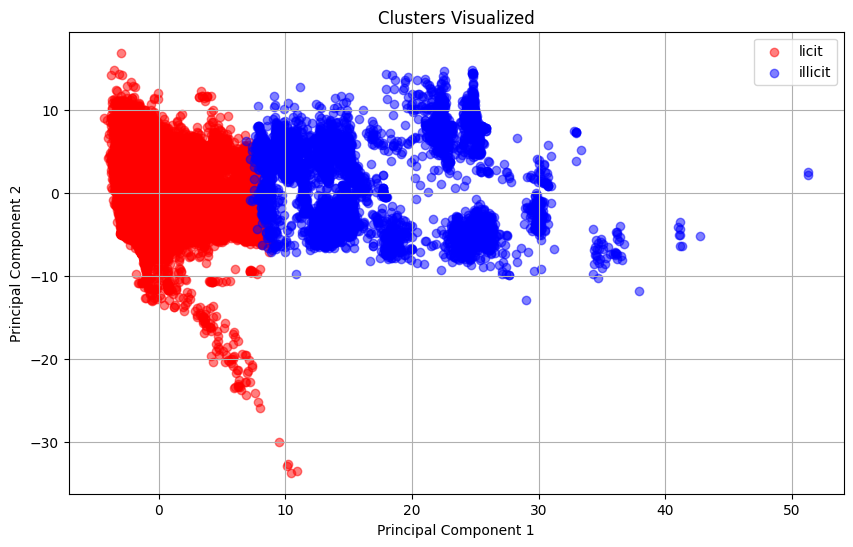

In [17]:
#plotting the results:
plt.figure(figsize=(10, 6))

plt.scatter(x_pca[clusters == 1, 0], x_pca[clusters == 1, 1], c='red', label='licit', alpha=0.5)
plt.scatter(x_pca[clusters == 2, 0], x_pca[clusters == 2, 1], c='blue', label='illicit', alpha=0.5)
# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualized')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [40]:
# Create a contingency table to compare original labels with predicted clusters
contingency_table = pd.crosstab(index=clusters, columns=df['label'], rownames=['Cluster'], colnames=['Original Label'])

print("\nContingency Table:")
print(contingency_table)

# Calculate totals per label in each cluster
totals_per_cluster = contingency_table.sum(axis=1)
print("\nTotals per cluster:")
print(totals_per_cluster)


Contingency Table:
Original Label     1      2  unknown
Cluster                             
1               4545  34067   155679
2                  0   7952     1526

Totals per cluster:
Cluster
1    194291
2      9478
dtype: int64


Clustering using only node-level features

In [37]:
number_node_level_features = 2
node_level_features = df.iloc[:,1:1+number_node_level_features].to_numpy()

pca = PCA()
scaler = StandardScaler()
#Standardize features by removing the mean and scaling to unit variance.
node_level_features_scaled = scaler.fit_transform(node_level_features)
node_level_features_pca = pca.fit_transform(node_level_features_scaled)
print(pca.explained_variance_ratio_*100)

[29.35899576 20.63271097 17.32933392 15.58742383 13.25459075  3.83694477]


In [38]:
clusters = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(node_level_features_pca)
clusters += 1
unique, counts = np.unique(clusters, return_counts=True)
print('Labels:', unique)
print('Size of clusters:', counts)

Labels: [1 2]
Size of clusters: [  2057 201712]


In [39]:
#The following results are obtained without apllying PCA
contingency_table = pd.crosstab(index=clusters, columns=df['label'], rownames=['Cluster'], colnames=['Original Label'])

print("Contingency Table:")
print(contingency_table)

# Calculate totals per label in each cluster
totals_per_cluster = contingency_table.sum(axis=1)
print("Totals per cluster:")
print(totals_per_cluster)

Contingency Table:
Original Label     1      2  unknown
Cluster                             
1                  1    225     1831
2               4544  41794   155374
Totals per cluster:
Cluster
1      2057
2    201712
dtype: int64


Clustering with the original dataset's features

In [55]:
dataset_features = 6
dataset_features = df.iloc[:,1+number_node_level_features:].to_numpy()

pca = PCA(12)
scaler = StandardScaler()
#Standardize features by removing the mean and scaling to unit variance.
dataset_features_scaled = scaler.fit_transform(dataset_features)
dataset_features_pca = pca.fit_transform(dataset_features_scaled)
print(pca.explained_variance_ratio_*100)

[10.42259228  6.46578969  5.50267698  4.5479627   4.02907219  3.88907999
  3.50324265  2.81590118  2.70329562  2.63726106  2.46685395  2.16594796]


In [56]:
clusters = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(dataset_features_pca)
clusters += 1
unique, counts = np.unique(clusters, return_counts=True)
print('Labels:', unique)
print('Size of clusters:', counts)#The following results are obtained without apllying PCA
contingency_table = pd.crosstab(index=clusters, columns=df['label'], rownames=['Cluster'], colnames=['Original Label'])

print("\nContingency Table:")
print(contingency_table)

# Calculate totals per label in each cluster
totals_per_cluster = contingency_table.sum(axis=1)
print("Totals per cluster:")
print(totals_per_cluster)

Labels: [1 2]
Size of clusters: [107644  96125]

Contingency Table:
Original Label     1      2  unknown
Cluster                             
1               2874  19943    84827
2               1671  22076    72378
Totals per cluster:
Cluster
1    107644
2     96125
dtype: int64


In [ ]:
import igraph as ig
import matplotlib.pyplot as plt

filtered_vertices = [v.index for v in tx_graph.vs if v['color'] in ['red', 'green']]

filtered_subgraph = tx_graph.subgraph(filtered_vertices)
fig, ax = plt.subplots(figsize=(20, 20)) 

ig.plot(
    filtered_subgraph,
    vertex_size=10,
    edge_width=0.5,
    bbox=(800, 800), 
    margin=50,
    target=ax
)

plt.show()
